In [16]:
# Import packages
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import TFDistilBertModel, DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

### Load Datasets

In [2]:
test = pd.read_csv('test_df_2.csv')

In [4]:
train = pd.read_csv('combined_train_df_2.csv')

In [5]:
test.head()

,id,dataset,text,text_clean,chunk_id,title,binary_label,label
0,LIAR 2_6178,LIAR 2,"According to the FBI, Mexican drug cartels are...",according to the fbi mexican drug cartels are ...,1,False,1,3.0
1,LIAR 2_18432,LIAR 2,Says Transportation Secretary Ray LaHood will ...,says transportation secretary ray lahood will ...,1,False,0,1.0
2,Kaggle 2 - News Project_53040,Kaggle 2 - News Project,the outlines of an agreement they say would st...,the outlines of an agreement they say would st...,3,False,1,NaN
3,Kaggle 3 - Fake News Detection_19847,Kaggle 3 - Fake News Detection,asks why MGM didn't notice the behavior of gun...,asks why mgm didnt notice the behavior of gunm...,8,False,1,NaN
4,Fakeddit_406006,Fakeddit,i made a us map and put a touch of red on her,i made a us map and put a touch of red on her,1,True,0,NaN


In [6]:
train.head()

,id,dataset,text,text_clean,chunk_id,title,binary_label,label
0,Fakeddit_0,Fakeddit,my walgreens offbrand mucinex was engraved wit...,my walgreens offbrand mucinex was engraved wit...,1,True,1,NaN
1,Fakeddit_1,Fakeddit,this concerned sink with a tiny hat,this concerned sink with a tiny hat,1,True,0,NaN
2,Fakeddit_2,Fakeddit,hackers leak emails from uae ambassador to us,hackers leak emails from uae ambassador to us,1,True,1,NaN
3,Fakeddit_3,Fakeddit,this flower in my neighborhood,this flower in my neighborhood,1,True,1,NaN
4,Fakeddit_4,Fakeddit,puppy taking in the view,puppy taking in the view,1,True,1,NaN


### Data Processing

In [7]:
# Remove LIAR 2 middle category (half-true & half-false)
combined = train[train['label']!=3]
test = test[test['label']!=3]

### DistilBERT

In [9]:
# Constants
BATCH_SIZE = 16
MAX_LEN = 60
SEED = 42

# Split into train/val
train, val = train_test_split(train, test_size=0.3, random_state=SEED)

In [10]:
# Prepare data
X_train = [str(x) for x in train['text'].values]
y_train = train['binary_label'].values

X_val = [str(x) for x in val['text'].values]
y_val = val['binary_label'].values

In [11]:
# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize
train_encodings = tokenizer(X_train, truncation=True, padding='max_length', max_length=MAX_LEN, return_tensors="tf")
val_encodings = tokenizer(X_val, truncation=True, padding='max_length', max_length=MAX_LEN, return_tensors="tf")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [12]:
# Build datasets
train_inputs = {
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask']
}
val_inputs = {
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask']
}


In [13]:
train_labels = tf.cast(y_train, tf.float32)
val_labels = tf.cast(y_val, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)) \
    .shuffle(buffer_size=len(X_train), seed=SEED) \
    .batch(BATCH_SIZE) \
    .cache().prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_inputs, val_labels)) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.AUTOTUNE)

In [18]:
from transformers import create_optimizer
# Model
model = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=1
)

optimizer, schedule = create_optimizer(
    init_lr=5e-5,
    num_train_steps=1000,
    num_warmup_steps=100
)
# Compile
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [19]:
# Train
model.summary()
history = model.fit(train_ds, validation_data=val_ds, epochs=1)

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
 dropout_58 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66954241 (255.41 MB)
Trainable params: 66954241 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
49242/49242 [==============================]

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

# Testing
X_test = test['text'].values
y_test = test['binary_label'].values

X_test = [str(x) for x in X_test]

test_encodings = tokenizer(X_test, truncation=True, padding='max_length', max_length=60, return_tensors="tf")

# Prepare dataset
inputs_test = {
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask']
}



In [27]:
# Predict
predictions = model.predict(inputs_test).logits
probs = tf.nn.sigmoid(predictions).numpy()
preds = (probs > 0.5).astype(int).flatten()

# Evaluate
print(classification_report(y_test, preds, target_names=['Fake', 'Real']))

605/605 [==============================] - 9s 13ms/step
              precision    recall  f1-score   support

        Fake       0.78      0.65      0.71      9333
        Real       0.72      0.83      0.77     10017

    accuracy                           0.74     19350
   macro avg       0.75      0.74      0.74     19350
weighted avg       0.75      0.74      0.74     19350



In [28]:
# Accuracy by dataset

preds_new = pd.DataFrame(preds,index=test.index)
concat = pd.concat([test,preds_new],axis=1)

concat.columns.values[-1] = 'preds'

concat['preds'].value_counts()

accuracy_df = (concat['preds'] == concat['binary_label']).groupby(concat['dataset']).mean()

accuracy_df

,0
dataset,
Fakeddit,0.802000
Kaggle 1 - Fake News,0.922750
Kaggle 2 - News Project,0.706000
Kaggle 3 - Fake News Detection,0.756250
LIAR 2,0.477015


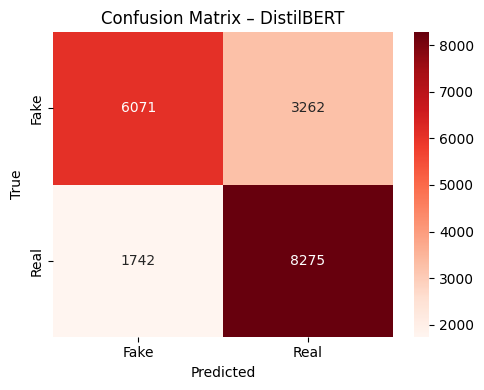

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds)


plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix – DistilBERT')
plt.tight_layout()
plt.show()
